In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
dynamic = pd.read_csv('./sph_dynamic.csv')
static = pd.read_csv('./sph_static.csv')

In [5]:
merge_df = pd.merge(dynamic, static, on = 'stay_id')

In [6]:
merge_df['icu_intime'] = pd.to_datetime(merge_df['icu_intime'], format = "%Y-%m-%d %H:%M:%S.%f")

for i in range(len(merge_df)):
        merge_df.loc[i, 'vent_start'] = pd.Timestamp(merge_df.loc[i, 'vent_start']).replace(year = merge_df.loc[i, 'icu_intime'].year)
        merge_df.loc[i, 'vent_end'] = pd.Timestamp(merge_df.loc[i, 'vent_end']).replace(year = merge_df.loc[i, 'icu_intime'].year)

merge_df['vent_start'] = pd.to_datetime(merge_df['vent_start'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['vent_end'] = pd.to_datetime(merge_df['vent_end'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['charttime'] = pd.to_datetime(merge_df['charttime'], format = "%Y-%m-%d %H:%M:%S.%f")

In [7]:
#Remove the chart data that is done after 12h in ICU
merge_df = merge_df[(merge_df['charttime'] - merge_df['icu_intime']).dt.total_seconds() <= 43200]  

#Remove the records of the patient that is intubated after 48h in ICU
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() <= 172800]

#Specific case: Last year of the day
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() >= 0]

In [8]:
#标准化，去除异常值
mean = np.mean(merge_df['vent_duration'])
std_dev = np.std(merge_df['vent_duration'])

merge_df['z_score'] = (merge_df['vent_duration'] - mean) / std_dev

merge_df = merge_df.loc[abs(merge_df['z_score']) <= 3]

In [9]:
#去除超过30天的数据
merge_df = merge_df.loc[(merge_df['icu_intime'] - merge_df['charttime']).apply(lambda x: x.total_seconds()) <= 31 * 60 * 60 * 60]

In [10]:
#去除缺失率高于40%的列
missing_percent = merge_df.isna().sum() / len(merge_df)

df = merge_df.drop(columns = missing_percent[missing_percent > 0.4].index)

In [11]:
df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score
17,34483718,2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
18,34483718,2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
19,34483718,2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
20,34483718,2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
21,34483718,2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,38307084,2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1,2153-12-19 02:35:00,2153-12-20 05:04:00,2153-12-21 06:00:00,24.933333,-0.270423
7020,39929091,2170-10-18 15:42:00,NaN,0.7,93.0,141.0,102.0,11.0,6.6,2170-10-18 15:21:13,2170-10-19 16:33:00,2170-10-20 00:00:00,7.450000,-0.573792
7021,37863848,2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8,2147-09-19 19:20:00,2147-09-20 19:00:00,2147-09-25 08:00:00,109.000000,1.188290
7022,33018891,2180-08-18 02:31:00,9.0,1.2,111.0,135.0,98.0,8.7,17.8,2180-08-18 00:52:00,2180-08-18 18:00:00,2180-08-19 12:00:00,18.000000,-0.390730


处理glucose异常值,去掉大于300的行

In [12]:
df = df.loc[df['glucose'] < 300]

In [13]:
df = df.reset_index(drop=True)

In [14]:
df.shape

(5325, 14)

In [15]:
# 用median策略插值
df = df.fillna(df.median())

C:\Users\Tcode9\AppData\Local\Temp\ipykernel_9740\2892663818.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.median())


In [16]:
#将icu_intime和vent_start相减作为新的feature
icu_intime = pd.to_datetime(df.iloc[:, -5])
vent_start = pd.to_datetime(df.iloc[:, -4])
time_diff = vent_start - icu_intime
# 将时间差转换为小时数，并将结果添加到 train_data 中
df['time_diff_hours'] = pd.to_timedelta(time_diff).dt.total_seconds() / 3600

In [17]:
df

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score,time_diff_hours
0,34483718,2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
1,34483718,2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
2,34483718,2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
3,34483718,2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
4,34483718,2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9,2118-01-06 23:52:45,2118-01-07 13:00:00,2118-01-08 10:00:00,21.000000,-0.338674,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1,2153-12-19 02:35:00,2153-12-20 05:04:00,2153-12-21 06:00:00,24.933333,-0.270423,26.483333
5321,39929091,2170-10-18 15:42:00,8.4,0.7,93.0,141.0,102.0,11.0,6.6,2170-10-18 15:21:13,2170-10-19 16:33:00,2170-10-20 00:00:00,7.450000,-0.573792,25.196389
5322,37863848,2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8,2147-09-19 19:20:00,2147-09-20 19:00:00,2147-09-25 08:00:00,109.000000,1.188290,23.666667
5323,33018891,2180-08-18 02:31:00,9.0,1.2,111.0,135.0,98.0,8.7,17.8,2180-08-18 00:52:00,2180-08-18 18:00:00,2180-08-19 12:00:00,18.000000,-0.390730,17.133333


In [18]:
df.to_csv('GrpAssignment_2_FinalPreprocess_data.csv', index=False)

In [19]:
num_stay_ids = df['stay_id'].nunique()
print('There are', num_stay_ids, 'unique stay_ids in the dataset.')

There are 1633 unique stay_ids in the dataset.


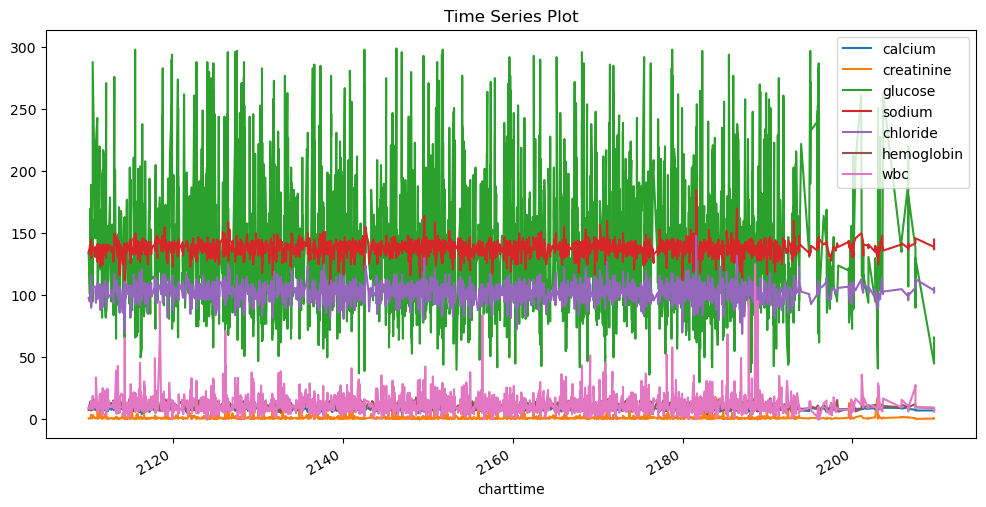

In [20]:
data = df.set_index('charttime')
data = data.iloc[:, 1: -6]
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax)
ax.set_title('Time Series Plot')
plt.show()

In [21]:
data

,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc
charttime,,,,,,,
2118-01-04 03:58:00,8.2,0.8,129.0,141.0,101.0,8.7,11.3
2117-12-25 04:00:00,8.3,0.6,110.0,140.0,104.0,8.0,5.0
2117-12-20 15:20:00,8.6,0.8,73.0,142.0,108.0,8.4,6.3
2117-12-31 05:22:00,8.0,0.9,140.0,136.0,102.0,8.2,7.3
2118-01-05 04:59:00,8.3,0.9,137.0,138.0,98.0,8.1,10.9
...,...,...,...,...,...,...,...
2153-12-18 22:50:00,10.1,0.9,140.0,136.0,99.0,15.7,7.1
2170-10-18 15:42:00,8.4,0.7,93.0,141.0,102.0,11.0,6.6
2147-09-20 03:57:00,8.5,1.0,104.0,141.0,102.0,11.4,13.8


In [22]:
# data2 = data.drop('glucose', axis=1)
# fig, ax = plt.subplots(figsize=(12, 6))
# data2.plot(ax=ax)
# ax.set_title('Time Series Plot')
# plt.show()

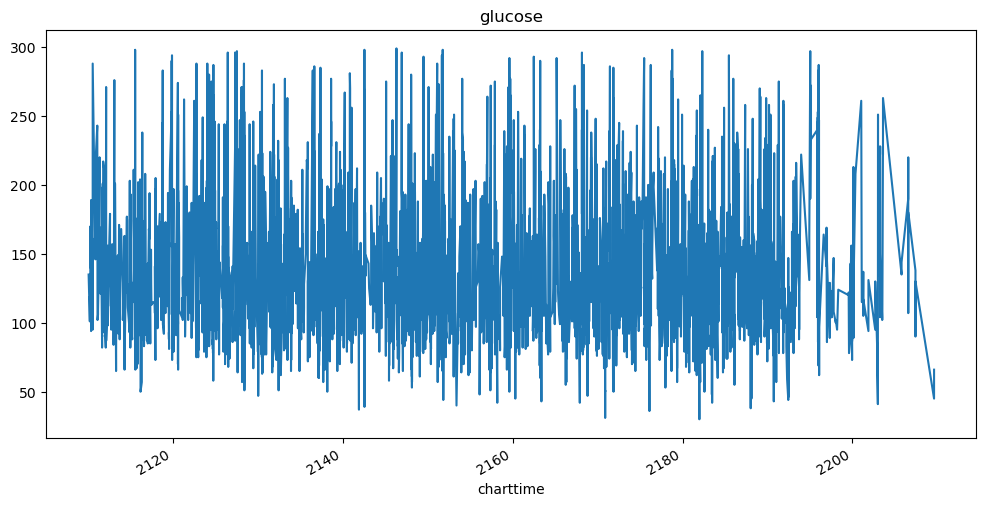

In [23]:
glucose_data = data['glucose']
fig, ax = plt.subplots(figsize=(12, 6))
glucose_data.plot(ax=ax)
ax.set_title('glucose')
plt.show()

In [24]:
#将glucose标准化
# mean_glu = np.mean(df['glucose'])
# std_dev_glu = np.std(df['glucose'])
# print(mean_glu,std_dev_glu)
# df['glucose'] = (df['glucose'] - mean_glu) / std_dev_glu

可视化探索

In [25]:
#按病人ID进行分组
groups = df.groupby('stay_id')

In [2]:
# #遍历每个病人的数据
# for name, group in groups:
#     # 绘制时间序列图
#     plt.plot(group['charttime'], group['glucose'], label=name)
#     plt.xlabel('Time')
#     plt.ylabel('glucose')
#     plt.title('Patient Data')
    
#     # 绘制自相关图
#     pd.plotting.autocorrelation_plot(group['glucose'])
#     plt.title('Autocorrelation Plot')
    
#     plt.show()

对数据集进行标准化

In [25]:
#转化为timestamp
df['charttime'] =  df['charttime'].apply(lambda x: x.timestamp())
df['icu_intime'] = df['icu_intime'].apply(lambda x: x.timestamp())
df['vent_start'] = df['vent_start'].apply(lambda x: x.timestamp())
df['vent_end'] = df['vent_end'].apply(lambda x: x.timestamp())

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5325 entries, 0 to 5324
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stay_id          5325 non-null   int64  
 1   charttime        5325 non-null   float64
 2   calcium          5325 non-null   float64
 3   creatinine       5325 non-null   float64
 4   glucose          5325 non-null   float64
 5   sodium           5325 non-null   float64
 6   chloride         5325 non-null   float64
 7   hemoglobin       5325 non-null   float64
 8   wbc              5325 non-null   float64
 9   icu_intime       5325 non-null   float64
 10  vent_start       5325 non-null   float64
 11  vent_end         5325 non-null   float64
 12  vent_duration    5325 non-null   float64
 13  z_score          5325 non-null   float64
 14  time_diff_hours  5325 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 624.1 KB


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df
df_scaled.iloc[:,2:-5] = pd.DataFrame(scaler.fit_transform(df.iloc[:,2:-5]), columns=df.iloc[:,2:-5].columns)

In [28]:
df_scaled

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score,time_diff_hours
0,34483718,4.670712e+09,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
1,34483718,4.669848e+09,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
2,34483718,4.669457e+09,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
3,34483718,4.670371e+09,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
4,34483718,4.670802e+09,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,38307084,5.805385e+09,2.162153,-0.388665,0.173620,-0.262135,-0.448813,2.734854,-0.513026,-0.077084,5.805493e+09,5.805583e+09,24.933333,-0.270423,26.483333
5321,39929091,6.336546e+09,0.007664,-0.494757,-0.856361,0.637961,-0.001707,0.466173,-0.576972,0.606998,6.336636e+09,6.336662e+09,7.450000,-0.573792,25.196389
5322,37863848,5.608238e+09,0.134398,-0.335619,-0.615301,0.637961,-0.001707,0.659252,0.343843,-0.331053,5.608292e+09,5.608685e+09,109.000000,1.188290,23.666667
5323,33018891,6.646847e+09,0.768072,-0.229527,-0.461900,-0.442154,-0.597849,-0.644033,0.855406,1.006639,6.646903e+09,6.646968e+09,18.000000,-0.390730,17.133333


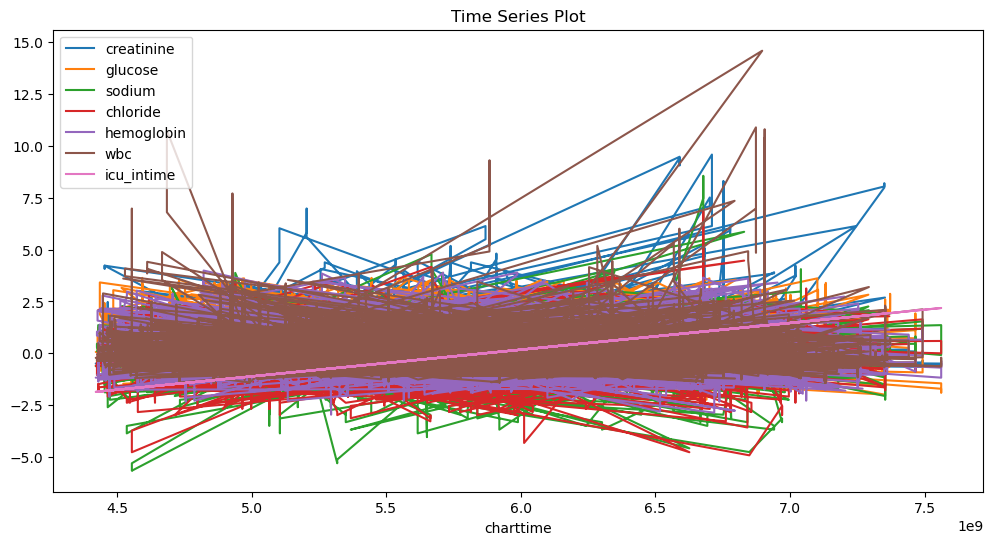

In [29]:
data_s = df_scaled.set_index('charttime')
data_s = data_s.iloc[:, 2: -5]
fig, ax = plt.subplots(figsize=(12, 6))
data_s.plot(ax=ax)
ax.set_title('Time Series Plot')
plt.show()

VARMA模型

In [30]:
import statsmodels.api as sm

total_rows = len(df)
split_point = int(total_rows * 0.8)

# 获取80%分位数对应的stay_id
split_stay_id = df.iloc[split_point]['stay_id']
print(total_rows,split_point,split_stay_id)
#分组
grouped = df.groupby('stay_id')

# 找到该stay_id出现的最后一行
last_row_of_stay_100 = grouped.get_group(split_stay_id).tail(1)
# 获取80%分界的行号
boundary_index = last_row_of_stay_100.index[0]
print(boundary_index)
# 划分数据集
train_data = df.iloc[:boundary_index, :]
test_data = df.iloc[boundary_index:, :]

5325 4260 31458920.0
4262


In [31]:
train_data

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_end,vent_duration,z_score,time_diff_hours
0,34483718,4.670712e+09,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
1,34483718,4.669848e+09,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
2,34483718,4.669457e+09,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
3,34483718,4.670371e+09,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
4,34483718,4.670802e+09,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,-1.538170,4.671004e+09,4.671079e+09,21.000000,-0.338674,13.120833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257,31458920,7.040254e+09,-0.626010,-0.070389,0.852970,2.258132,1.637682,-0.113065,-0.193299,1.513277,7.040358e+09,7.040488e+09,36.116667,-0.076372,39.881667
4258,31458920,7.040232e+09,-1.006214,-0.123435,0.874884,3.338247,2.084788,0.707522,1.047242,1.513277,7.040358e+09,7.040488e+09,36.116667,-0.076372,39.881667
4259,31458920,7.040139e+09,0.514602,-0.123435,0.436594,4.058323,1.786717,-0.113065,-0.193299,1.513277,7.040358e+09,7.040488e+09,36.116667,-0.076372,39.881667
4260,31458920,7.040209e+09,-0.119071,-0.229527,0.633825,3.338247,2.084788,1.383299,-1.011800,1.513277,7.040358e+09,7.040488e+09,36.116667,-0.076372,39.881667


In [32]:
test_data.shape

(1063, 15)

In [33]:
x_train = train_data.iloc[:, 1:11]
y_train = train_data.iloc[:, 12]
x_test = test_data.iloc[:, 1:11]
y_test = test_data.iloc[:, 12]

In [34]:
# x_train['charttime'] =  x_train['charttime'].apply(lambda x: x.timestamp())
# x_train['icu_intime'] = x_train['icu_intime'].apply(lambda x: x.timestamp())
# x_train['vent_start'] = x_train['vent_start'].apply(lambda x: x.timestamp())

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4262 entries, 0 to 4261
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   charttime   4262 non-null   float64
 1   calcium     4262 non-null   float64
 2   creatinine  4262 non-null   float64
 3   glucose     4262 non-null   float64
 4   sodium      4262 non-null   float64
 5   chloride    4262 non-null   float64
 6   hemoglobin  4262 non-null   float64
 7   wbc         4262 non-null   float64
 8   icu_intime  4262 non-null   float64
 9   vent_start  4262 non-null   float64
dtypes: float64(10)
memory usage: 333.1 KB


In [36]:
x_train

,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start
0,4.670712e+09,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,-1.538170,4.671004e+09
1,4.669848e+09,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,-1.538170,4.671004e+09
2,4.669457e+09,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,-1.538170,4.671004e+09
3,4.670371e+09,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,-1.538170,4.671004e+09
4,4.670802e+09,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,-1.538170,4.671004e+09
...,...,...,...,...,...,...,...,...,...,...
4257,7.040254e+09,-0.626010,-0.070389,0.852970,2.258132,1.637682,-0.113065,-0.193299,1.513277,7.040358e+09
4258,7.040232e+09,-1.006214,-0.123435,0.874884,3.338247,2.084788,0.707522,1.047242,1.513277,7.040358e+09
4259,7.040139e+09,0.514602,-0.123435,0.436594,4.058323,1.786717,-0.113065,-0.193299,1.513277,7.040358e+09
4260,7.040209e+09,-0.119071,-0.229527,0.633825,3.338247,2.084788,1.383299,-1.011800,1.513277,7.040358e+09


In [37]:
# # 绘制自相关图（ACF）和偏自相关图（PACF）
# fig, ax = plt.subplots(figsize=(10, 8))
# sm.graphics.tsa.plot_acf(x_train, lags=30, ax=ax)
# fig, ax = plt.subplots(figsize=(10, 8))
# sm.graphics.tsa.plot_pacf(x_train, lags=30, ax=ax)

In [38]:
# 相关系数矩阵
corr_matrix = train_data.corr()

<AxesSubplot:>

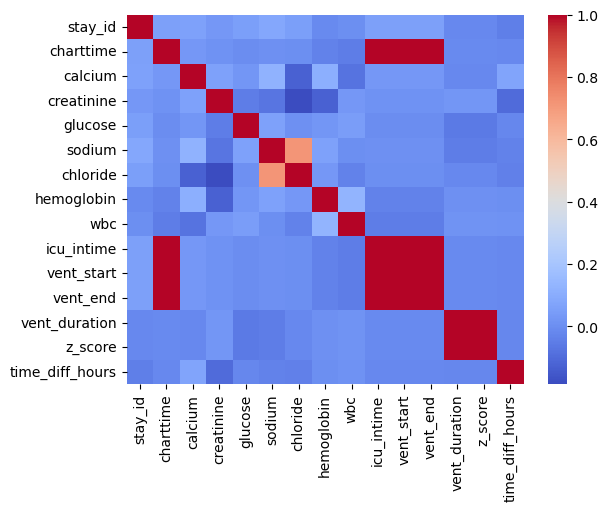

In [39]:
# 热力图
sns.heatmap(corr_matrix, cmap='coolwarm')

In [40]:
x_train_test = train_data

In [41]:
x_train_test = x_train_test.drop(['charttime','icu_intime', 'vent_start', 'vent_end','z_score'], axis=1)

In [42]:
x_train_test

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,vent_duration,time_diff_hours
0,34483718,-0.245806,-0.441711,-0.067439,0.637961,-0.150743,-0.644033,0.024116,21.000000,13.120833
1,34483718,-0.119071,-0.547803,-0.483814,0.457941,0.296363,-0.981921,-0.781597,21.000000,13.120833
2,34483718,0.261133,-0.441711,-1.294651,0.817980,0.892505,-0.788842,-0.615339,21.000000,13.120833
3,34483718,-0.499275,-0.388665,0.173620,-0.262135,-0.001707,-0.885382,-0.487448,21.000000,13.120833
4,34483718,-0.119071,-0.388665,0.107877,0.097903,-0.597849,-0.933651,-0.027041,21.000000,13.120833
...,...,...,...,...,...,...,...,...,...,...
4257,31458920,-0.626010,-0.070389,0.852970,2.258132,1.637682,-0.113065,-0.193299,36.116667,39.881667
4258,31458920,-1.006214,-0.123435,0.874884,3.338247,2.084788,0.707522,1.047242,36.116667,39.881667
4259,31458920,0.514602,-0.123435,0.436594,4.058323,1.786717,-0.113065,-0.193299,36.116667,39.881667
4260,31458920,-0.119071,-0.229527,0.633825,3.338247,2.084788,1.383299,-1.011800,36.116667,39.881667


In [43]:
from statsmodels.tsa.statespace.varmax import VARMAX
#定义VARMA模型
model = VARMAX(x_train_test, order=(2, 2))

D:\Tcode9\NUS\IT5006\Anaconda\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [44]:
# 拟合VARMA模型
result = model.fit(maxiter=500, disp=True)

D:\Tcode9\NUS\IT5006\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
test_data = test_data.drop(['charttime','icu_intime', 'vent_start', 'vent_end','z_score'], axis=1)

In [61]:
# Make predictions on test data
predictions = result.forecast(steps=len(test_data))

# Calculate error metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
rmse = mean_squared_error(test_data, predictions, squared=False)
r2 = r2_score(test_data, predictions)
# nobs = len(train_data) + len(test_data)
# loglik = model.loglike(params=model.params)
# aic = -2*loglik/nobs + 2*(len(model.params))/nobs
# bic = -2*loglik/nobs + np.log(nobs)*(len(model.params))/nobs

In [62]:
print('MSE: ', mse)
print('R²: ', r2)
print("MAE: ", mae)
print("RMSE: ", rmse)
# print("AIC: ", aic)
# print("BIC: ", bic)

MSE:  818761115728.2965
R²:  -0.02534823516412028
MAE:  245424.30316308924
RMSE:  286145.43565566617


<function matplotlib.pyplot.show(close=None, block=None)>

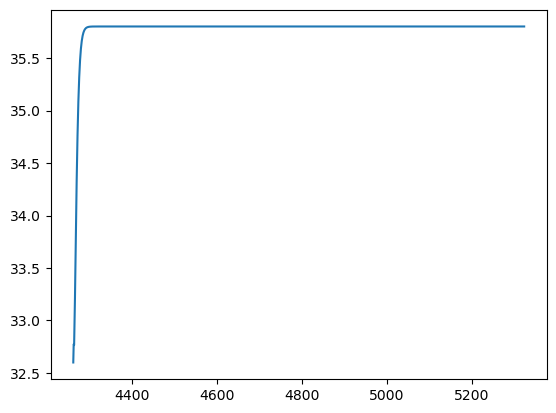

In [57]:
#plt.plot(test_data['vent_duration'].values)
plt.plot(predictions['vent_duration'])
plt.show